In [1]:
%load_ext autoreload

%autoreload 2

from RNN2DFA.LSTM import LSTMNetwork
# from GRU import GRUNetwork
from RNN2DFA.RNNClassifier import RNNClassifier
from RNN2DFA.Training_Functions import mixed_curriculum_train
import Tomita_Grammars 
from RNN2DFA.Training_Functions import make_test_set,make_train_set_for_target
from RNNexplainer import Explainer
import pandas as pd
import LTL2DFA as ltlf2dfa
from RNN2DFA.Extraction import extract





In [2]:
# Reber grammar
from specific_examples import Reber_Grammar
rg=Reber_Grammar()
alphabet=rg.alphabet
generator_dfa=rg
sample_train_set=[]
for i in range(100):
    seq, _, _ = rg.get_one_example(maxLength=10)
    sample_train_set.append(seq)
    # print(rg.classify_word(rg.sequenceToWord(seq)))

In [3]:
import specific_examples
generator_dfa=specific_examples.Example1()
target_formula = generator_dfa.target_formula
alphabet = generator_dfa.alphabet
query_formulas = generator_dfa.query_formulas


In [4]:
from sklearn.model_selection import train_test_split
def dict2lists(dictionary):
    X,y=[],[]
    for key in dictionary:
        X.append(key)
        y.append(dictionary[key])
    return X,y

def lists2dict(x,y):
    # both x and y should have same length
    assert len(x)==len(y), "Error dimension"
    d={}
    n=len(x)
    for idx in range(n):
        d[x[idx]]=y[idx]
    return d

# for each example, specify a different generating function


if(target_formula == "balanced parentheses"):
    train_set = generator_dfa.get_balanced_parantheses_train_set(100, 2, 50,max_train_samples_per_length=300,                                                         search_size_per_length=20,lengths=[i+1 for i in range(50)])
    

elif(target_formula == "email match"):
    train_set = make_train_set_for_target(generator_dfa.classify_word, alphabet,lengths=[i+1 for i in range(50)],
                                          max_train_samples_per_length=1000,
                                          search_size_per_length=3000, deviation = 20)

    # generate more examples that match the regular expression
    matching_strings = generator_dfa.generate_matching_strings(
        n=1080, max_length=50)
    for string in matching_strings:
        train_set[string] = True
    
    

elif(target_formula == "alternating bit protocol"):
    train_set = make_train_set_for_target(generator_dfa.classify_word, alphabet,lengths=[i+1 for i in range(50)],
                                          max_train_samples_per_length=100,
                                          search_size_per_length=30, deviation = 25)

    # generate more examples that match the regular expression
    matching_strings = generator_dfa.generate_matching_strings(
        n=1050, max_sequence_length=50)
    for string in matching_strings:
        train_set[string] = True

else:
    train_set = make_train_set_for_target(generator_dfa.classify_word, alphabet,lengths=[i+1 for i in range(50)],
                                          max_train_samples_per_length=100,
                                          search_size_per_length=300, deviation = 20)


    

# print ratio
cnt = 0
examples_per_length=[0 for i in range(51)]
for key in train_set:
    if(train_set[key]):
        cnt += 1
    examples_per_length[len(key)] += 1

total_samples = len(train_set) 
print("out of ", total_samples, " sequences", cnt , " are positive. (percent: ", float(cnt/total_samples), ")")
print("examples per length:", examples_per_length)
    
# split train:test
X, y = dict2lists(train_set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
train_set = lists2dict(X_train, y_train)
test_set = lists2dict(X_test, y_test)
print("size of train set:", len(train_set))
print("size of test set:", len(test_set))

made train set of size: 1239 , of which positive examples: 145
out of  1239  sequences 145  are positive. (percent:  0.11702986279257466 )
examples per length: [0, 3, 9, 27, 52, 82, 60, 54, 52, 38, 32, 30, 28, 28, 20, 22, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
size of train set: 991
size of test set: 248


In [5]:
fout=open("output/log.txt", "a")
fout.write(".........................................................................\n")
fout.write("Target: "+ target_formula)
print(target_formula)
fout.write("\n")
fout.close()


# define rnn
rnn = RNNClassifier(alphabet,num_layers=1,hidden_dim=10,RNNClass = LSTMNetwork)


# train the model
mixed_curriculum_train(rnn,train_set,stop_threshold = 0.0005)
rnn.renew()  
dfa_from_rnn=rnn 
# statistics

def percent(num,digits=2):
    tens = pow(10,digits)
    return int(100*num*tens)/tens

print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

n = len(test_set)
print("test set size:", n)
pos = 0
rnn_target = 0
for w in test_set:
    if generator_dfa.classify_word(w):
        pos+=1

    if dfa_from_rnn.classify_word(w)==generator_dfa.classify_word(w):
        rnn_target+=1
print("rnn score against target on test set:                             ",rnn_target,"("+str(percent(rnn_target/n))+")")
test_set_size= len(test_set)
test_acc = percent(rnn_target/test_set_size)

# dfa_from_rnn=generator_dfa

G(~a)
The dy.parameter(...) call is now DEPRECATED.
        There is no longer need to explicitly add parameters to the computation graph.
        Any used parameter will be added automatically.
current average loss is:  0.005363256785764612
current average loss is:  0.0008444724996172061
classification loss on last batch was: 0.0004894845409329387
testing on train set, i.e. test set is train set
test set size: 248
rnn score against target on test set:                              248 (100.0)


true


positive traces---> 
[]


negative traces---> 
[]



Learning formula with depth 0
learned LTL formula: true
Learning took:  0.05406618118286133  s
No positive counterexample found
EQ test took  0.03304290771484375  s
new counterexample: a  should be rejected by implementation


positive traces---> 
[]


negative traces---> 
['a']



0  iteration complete



Learning formula with depth 0
learned LTL formula: false
Learning took:  0.05552482604980469  s
EQ test took  0.0016529560089111328  s
new counterexample:   should be accepted by implementation


positive traces---> 
['']


negative traces---> 
['a']



1  iteration complete



start formula depth: 1
increasing formula depth to  2
Before normalization: (! x0)
Learning formula with depth 1
learned LTL formula: (~ a)
Learning took:  0.1160271167755127  s
No positive counterexample found
EQ test took  0.07735514640808105  s
new counterexample: ba  should be rejected by implementation


positive traces---> 
['']


negative trace

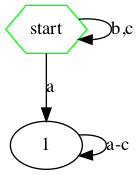


Time taken to extract lstar-dfa: 0.15596985816955566
number of states of the dfa: 2
returned flag: True
Explanation matches RNN: 100.0
RNN matches ground truth: 100.0
Explanation matches ground truth: 100.0
Lstar matches RNN: 100.0
Lstar matches ground truth: 100.0
target query explanation status  test accuracy  rnn score  explanation score  explanation score on ground truth  extraction time revised delta revised epsilon counterexamples train size test size ltl_depth lstar_states  lstar explanation score  lstar explanation score on ground truth  lstar extraction time lstar_status
 G(~a)  true   (G (~ a))   True          100.0      100.0              100.0                              100.0         0.709737          None            None       [a, , ba]        991       248         2            2                    100.0                                    100.0                0.15597         True


In [9]:
timeout = 15
maximum_sequence_length = 50
maximum_formula_depth = 50
epsilon = 0.05
delta = 0.05

# use a query LTL formula
query_formula="true"
print(query_formula)
query_dfa=ltlf2dfa.translate_ltl2dfa(alphabet=[character for character in alphabet],formula=query_formula, token="bal")
# print(query_dfa)
"""  
Create initial samples
"""


from RNNexplainer import Traces
traces=Traces(rnn, alphabet, token="bal")
traces.label_from_network([])
traces.write_in_file()




from PACTeacher.pac_teacher import PACTeacher as Teacher 
explainer=Explainer(alphabet=[character for character in alphabet], token="bal")
teacher = Teacher(dfa_from_rnn,epsilon=.03, delta=.03, max_trace_length=20, max_formula_depth=10, query_dfa=query_dfa)



import time
start_time=time.time()
from multiprocessing import Process, Queue
explainer, flag= teacher.teach(explainer, traces, timeout = 2)
end_time=time.time()


print("\n\nepsilon=", teacher.epsilon, "delta=", teacher.delta, "max_trace_length=", teacher.max_trace_length)
print("query:", query_formula)
print("final ltl: ", explainer.ltl)

fout=open("output/log.txt", "a")
fout.write("\n\nquery: "+query_formula)
fout.write("\nfinal LTL: "+ explainer.ltl)

new_delta = None
new_epsilon = None
if(not flag):
    fout.write(" [incomplete]")
    print("incomplete formula")
    new_delta, new_epsilon = teacher.calculate_revised_delta_and_epsilon()
    print(new_delta, new_epsilon)

fout.write("\n\n")

print("returned counterexamples:", teacher.returned_counterexamples)

print("\nTime taken:", end_time-start_time)
fout.close()


fout=open("output/log.txt", "a")


# compare with dfa from lstar_algorithm
start_time_lstar = time.time()
dfa_lstar, lstar_flag = extract(rnn, query=query_dfa, max_trace_length=maximum_sequence_length, epsilon=delta,
                            delta=delta, time_limit=10, initial_split_depth=10, starting_examples=[])
end_time_lstar = time.time()

dfa_lstar.draw_nicely(filename= target_formula+":"+query_formula)
print("\nTime taken to extract lstar-dfa:", end_time_lstar-start_time_lstar)
print("number of states of the dfa:", len(dfa_lstar.Q))
print("returned flag:", lstar_flag)


performance_explanation_with_rnn = performance_rnn_with_groundtruth = performance_explanation_with_groundtruth = 0
lstar_performance_explanation_with_rnn = lstar_performance_explanation_with_groundtruth = 0

test_set_size = 0

for w in train_set:
    if(query_dfa.classify_word(w)):
        test_set_size += 1
        verdict_rnn = dfa_from_rnn.classify_word(w)
        verdict_target = generator_dfa.classify_word(w)
        verdict_ltl = explainer.dfa.classify_word(w)
        verdict_lstar = dfa_lstar.classify_word(w)

        if verdict_rnn == verdict_ltl:
            performance_explanation_with_rnn += 1
        if verdict_rnn == verdict_target:
            performance_rnn_with_groundtruth += 1
        if verdict_ltl == verdict_target:
            performance_explanation_with_groundtruth += 1
        
        if verdict_rnn == verdict_lstar:
            lstar_performance_explanation_with_rnn += 1
        if verdict_lstar == verdict_target:
            lstar_performance_explanation_with_groundtruth += 1
        

if(test_set_size != 0):
    print("Explanation matches RNN:", str(
        percent(performance_explanation_with_rnn/test_set_size)))

    print("RNN matches ground truth:", str(
        percent(performance_rnn_with_groundtruth/test_set_size)))

    print("Explanation matches ground truth:", str(
        percent(performance_explanation_with_groundtruth/test_set_size)))
    
    print("Lstar matches RNN:", str(
        percent(lstar_performance_explanation_with_rnn/test_set_size)))

    print("Lstar matches ground truth:", str(
        percent(lstar_performance_explanation_with_groundtruth/test_set_size)))


fout.close()

# report in a pandas file
result = pd.DataFrame(columns=['target',
                                'query',
                                'explanation',
                                'status',
                                'test accuracy',
                                'rnn score',
                                'explanation score',
                                'explanation score on ground truth',
                                'extraction time',
                                'revised delta',
                                'revised epsilon',
                                'counterexamples',
                                'train size',
                                'test size',
                                'ltl_depth',
                                'lstar_states',
                                'lstar explanation score',
                                'lstar explanation score on ground truth',
                                'lstar extraction time',
                                'lstar_status'
                                ])

if(test_set_size != 0):
    result = result.append(
        {
            'target': target_formula,
            'query': query_formula,
            'explanation': explainer.ltl,
            'status': flag,
            'test accuracy': test_acc,
            'rnn score': percent(performance_rnn_with_groundtruth/test_set_size),
            'explanation score': percent(performance_explanation_with_rnn/test_set_size),
            'explanation score on ground truth': percent(performance_explanation_with_groundtruth/test_set_size),
            'extraction time': end_time-start_time,
            'revised delta': new_delta,
            'revised epsilon': new_epsilon,
            'counterexamples': teacher.returned_counterexamples,
            'train size': len(train_set),
            'test size': len(test_set),
            "ltl_depth": explainer.formula_depth,
            "lstar_states": len(dfa_lstar.Q),
            'lstar explanation score': percent(lstar_performance_explanation_with_rnn/test_set_size),
            'lstar explanation score on ground truth': percent(lstar_performance_explanation_with_groundtruth/test_set_size),
            'lstar extraction time': end_time_lstar - start_time_lstar,
            'lstar_status': lstar_flag
                                
        }, ignore_index=True
    )
else:
    result = result.append(
        {
            'target': target_formula,
            'query': query_formula,
            'explanation': explainer.ltl,
            'status': flag,
            'test accuracy': test_acc,
            'rnn score': None,
            'explanation score': None,
            'explanation score on ground truth': None,
            'extraction time': end_time-start_time,
            'revised delta': new_delta,
            'revised epsilon': new_epsilon,
            'counterexamples': teacher.returned_counterexamples,
            'train size': len(train_set),
            'test size': len(test_set),
            'train size': len(train_set),
            'test size': len(test_set),
            "ltl_depth": explainer.formula_depth,
            "lstar_states": len(dfa_lstar.Q),
            'lstar explanation score': None,
            'lstar explanation score on ground truth': None,
            'lstar extraction time': end_time_lstar - start_time_lstar,
            'lstar_status': lstar_flag
            
        }, ignore_index=True
    )
print(result.to_string(index=False))
result.to_csv('output/result.csv', header=False, index=False, mode='a')
